# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

## 3.1 Importing Libraries and Reading Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#change display setting options to remove display limit
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
#read in data to dataframe
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

CUST_ID  ACCOUNT_TENURE  ACCT_CNT_SERVICES   AGE       CFU  \
INDEX                                                               
1            1              46                  1  30.0  CONSUMER   
2            2              60                  3  55.0  CONSUMER   
3            5              65                  1  29.0  CONSUMER   
4            6              31                  1  51.0  CONSUMER   
5            8              95                  1  31.0  CONSUMER   

       SERVICE_TENURE  PLAN_ACCESS_FEE BYO_PLAN_STATUS  PLAN_TENURE  \
INDEX                                                                 
1                  46            54.54         NON BYO           15   
2                  59            54.54         NON BYO            5   
3                  65            40.90             BYO           15   
4                  31            31.81         NON BYO           31   
5                  95            54.54         NON BYO            0   

       MONTHS_OF_CONTRACT_REMAINING  LAST_FX_CONTRACT_DURATION  \
INDEX                                                            
1                                 0                         24   
2                                 0                         24   
3                                 0                         12   
4                                 0                         24   
5                                 0                         24   

      CONTRACT_STATUS  PREV_CONTRACT_DURATION HANDSET_USED_BRAND  CHURN_IND  \
INDEX                                                                         
1        OFF-CONTRACT                      24            SAMSUNG          1   
2        OFF-CONTRACT                      24              APPLE          1   
3        OFF-CONTRACT                      12              APPLE          1   
4        OFF-CONTRACT                      24              APPLE          1   
5        OFF-CONTRACT                      24              APPLE          1   

       MONTHLY_SPEND COUNTRY_METRO_REGION STATE  RECON_SMS_NEXT_MTH  \
INDEX                                                                 
1              61.40              COUNTRY    WA                 NaN   
2              54.54                METRO   NSW                 NaN   
3               2.50              COUNTRY    WA                 NaN   
4               6.48              COUNTRY   VIC                 NaN   
5             100.22                METRO   NSW                 NaN   

       RECON_TELE_NEXT_MTH  RECON_EMAIL_NEXT_MTH  
INDEX                                             
1                      NaN                   NaN  
2                      NaN                   NaN  
3                      NaN                   NaN  
4                      NaN                   NaN  
5                      NaN                   NaN

For purposes of investigating churn the `RECON` fields were dropped from the table. 

In [4]:
#dropping RECON fields 
churn.drop(columns=['RECON_SMS_NEXT_MTH', 'RECON_TELE_NEXT_MTH', 'RECON_EMAIL_NEXT_MTH'], inplace=True)
churn.head()

CUST_ID  ACCOUNT_TENURE  ACCT_CNT_SERVICES   AGE       CFU  \
INDEX                                                               
1            1              46                  1  30.0  CONSUMER   
2            2              60                  3  55.0  CONSUMER   
3            5              65                  1  29.0  CONSUMER   
4            6              31                  1  51.0  CONSUMER   
5            8              95                  1  31.0  CONSUMER   

       SERVICE_TENURE  PLAN_ACCESS_FEE BYO_PLAN_STATUS  PLAN_TENURE  \
INDEX                                                                 
1                  46            54.54         NON BYO           15   
2                  59            54.54         NON BYO            5   
3                  65            40.90             BYO           15   
4                  31            31.81         NON BYO           31   
5                  95            54.54         NON BYO            0   

       MONTHS_OF_CONTRACT_REMAINING  LAST_FX_CONTRACT_DURATION  \
INDEX                                                            
1                                 0                         24   
2                                 0                         24   
3                                 0                         12   
4                                 0                         24   
5                                 0                         24   

      CONTRACT_STATUS  PREV_CONTRACT_DURATION HANDSET_USED_BRAND  CHURN_IND  \
INDEX                                                                         
1        OFF-CONTRACT                      24            SAMSUNG          1   
2        OFF-CONTRACT                      24              APPLE          1   
3        OFF-CONTRACT                      12              APPLE          1   
4        OFF-CONTRACT                      24              APPLE          1   
5        OFF-CONTRACT                      24              APPLE          1   

       MONTHLY_SPEND COUNTRY_METRO_REGION STATE  
INDEX                                            
1              61.40              COUNTRY    WA  
2              54.54                METRO   NSW  
3               2.50              COUNTRY    WA  
4               6.48              COUNTRY   VIC  
5             100.22                METRO   NSW

## 3.2 Exploring the data 

In [5]:
#Data shape
churn.shape

(46206, 18)

In [6]:
#Attribute info
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46206 entries, 1 to 46206
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CUST_ID                       46206 non-null  int64  
 1   ACCOUNT_TENURE                46206 non-null  int64  
 2   ACCT_CNT_SERVICES             46206 non-null  int64  
 3   AGE                           46130 non-null  float64
 4   CFU                           46206 non-null  object 
 5   SERVICE_TENURE                46206 non-null  int64  
 6   PLAN_ACCESS_FEE               46206 non-null  float64
 7   BYO_PLAN_STATUS               46206 non-null  object 
 8   PLAN_TENURE                   46206 non-null  int64  
 9   MONTHS_OF_CONTRACT_REMAINING  46206 non-null  int64  
 10  LAST_FX_CONTRACT_DURATION     46206 non-null  int64  
 11  CONTRACT_STATUS               46206 non-null  object 
 12  PREV_CONTRACT_DURATION        46206 non-null  int64  
 13  H

There are 18 attributes. 6 of which are categorical attributes and 12 are numeric attributes.
The Categorical attributes will need to be converted into dummy variables.  
`CUST_ID` appears to be a unique identifier for each row. `CUST_ID` will need to be checked to ensure there are no duplicate rows.

In [7]:
#Types within categorical data
churn['CFU'].value_counts()

CONSUMER          39087
SMALL BUSINESS     7119
Name: CFU, dtype: int64

In [8]:
churn['BYO_PLAN_STATUS'].value_counts()

NON BYO    35475
BYO        10731
Name: BYO_PLAN_STATUS, dtype: int64

In [9]:
churn['CONTRACT_STATUS'].value_counts()

ON-CONTRACT     28281
OFF-CONTRACT    12460
NO-CONTRACT      5465
Name: CONTRACT_STATUS, dtype: int64

In [10]:
churn['HANDSET_USED_BRAND'].value_counts()

APPLE      24805
SAMSUNG    13439
GOOGLE      2536
UNKNOWN     2300
OTHER       1796
HUAWEI      1330
Name: HANDSET_USED_BRAND, dtype: int64

In [11]:
churn['COUNTRY_METRO_REGION'].value_counts()

METRO      31826
COUNTRY    14379
Name: COUNTRY_METRO_REGION, dtype: int64

In [12]:
churn['STATE'].value_counts()

NSW    15867
VIC    12510
QLD     9675
WA      3860
SA      2957
ACT     1003
TAS      302
NT        31
Name: STATE, dtype: int64

In [13]:
#CUST_ID unique values
dup = churn['CUST_ID'].duplicated().value_counts().to_frame()
print(f'The number of duplicated CUST_ID is: {churn.shape[0]-dup.iloc[0][0]} ')

The number of duplicated CUST_ID is: 0 


As there are no duplicated rows it can be assumed that each row represents a unique customer.

In [14]:
print(f'The number of customers in the dataset is: {churn.shape[0]}' )

The number of customers in the dataset is: 46206


In [15]:
#descirptive statistics of numeric values
churn_num = churn.select_dtypes(exclude=['bool_','object_'])
churn_num = churn_num.drop(columns= ['CUST_ID', 'CHURN_IND'])
round(churn_num.describe(), 2)

ACCOUNT_TENURE  ACCT_CNT_SERVICES       AGE  SERVICE_TENURE  \
count        46206.00           46206.00  46130.00        46206.00   
mean            45.87               1.56     41.41           50.32   
std             33.08               0.84     15.26           51.93   
min              0.00               1.00     -4.00            0.00   
25%             14.00               1.00     28.00           11.00   
50%             44.00               1.00     40.00           35.00   
75%             77.00               2.00     52.00           69.00   
max            120.00               4.00    116.00          259.00   

       PLAN_ACCESS_FEE  PLAN_TENURE  MONTHS_OF_CONTRACT_REMAINING  \
count         46206.00     46206.00                      46206.00   
mean             51.36        10.85                          8.24   
std              20.86         9.77                          8.34   
min               8.18         0.00                          0.00   
25%              36.36         3.00                          0.00   
50%              54.54         8.00                          7.00   
75%              72.72        16.00                         16.00   
max             234.54       147.00                         24.00   

       LAST_FX_CONTRACT_DURATION  PREV_CONTRACT_DURATION  MONTHLY_SPEND  
count                   46206.00                46206.00       46206.00  
mean                       20.35                   15.25          75.19  
std                         8.03                   10.98          73.52  
min                         0.00                    0.00           1.02  
25%                        24.00                    0.00          36.36  
50%                        24.00                   24.00          54.54  
75%                        24.00                   24.00          84.53  
max                        36.00                   36.00        1965.89

The descriptive statistics for the majority of the attributes seem resonable. 

There are some issues with the `AGE` attirbute. Problems could be arrising due to the differences in CFU type. It is reasonable for a small business to have a younger or older age compared to that of a consumer.

The spread of the `MONTHLY_SPEND` looks large and may be a result of a number of outliers within this attribute. 

### 3.2.1 Investigating Age

In [16]:
#investigating ages >95
churn['CFU'].loc[(churn['AGE'] > 95)].value_counts()

SMALL BUSINESS    50
CONSUMER          10
Name: CFU, dtype: int64

In [17]:
#investigating ages <15
churn['CFU'].loc[(churn['AGE'] < 15)].value_counts()

SMALL BUSINESS    17
CONSUMER           2
Name: CFU, dtype: int64

These values show that the majority of customers with an AGE < 15 or > 95 are SMALL BUSINESSES. 

It should be noted that the differences between `CFU` types and their respective relationship with the `AGE` attribute may create adverse noise and effect  model accuracy. This could be addressed by running two separate analysis on the two `CFU` types which may lead to a more accurate model. 

For the purpose of this model `CFU` and the corresponding `AGE` attribute was left unchanged.


### 3.2.2 Investigating Monthly Spend

Text(0.5, 1.0, 'MONTHLY_SPEND')

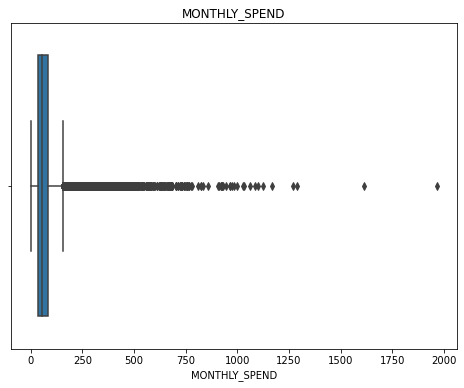

In [18]:
#identifying and removing outliers
plt.figure(figsize=(8,6))
ax = sns.boxplot(churn['MONTHLY_SPEND'])
ax.set_title('MONTHLY_SPEND')

The data for MONTHLY_SPEND is heavily right skewed. This is due to a number of outliers with large MONTHLY_SPEND amounts. These values have a disproportionate effect on the descriptive statistics and may impact on the accuracey of the model. They will be removed.

In [19]:
#identify outlier ranges
# Function to detect outlier
def find_anomalies(data):
    #define a list to accumlate anomalies
    anomalies = []
    
    # Set upper and lower limit to 3 standard deviation
    data_std = data.std()
    data_mean = data.mean()
    anomaly_cut_off = data_std * 3
    
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off
    return (lower_limit,upper_limit)

spend_lim =find_anomalies(churn['MONTHLY_SPEND'])

print(f'The lower and upper limit for MONTHLY_SPEND: {spend_lim}')

The lower and upper limit for MONTHLY_SPEND: (-145.36909535169406, 295.74515300655474)


In [20]:
#drop outliers from table
churn.drop(churn[churn["MONTHLY_SPEND"] > find_anomalies(churn["MONTHLY_SPEND"])[1]].index, inplace=True)

### 3.2.3 Investigating NULL values

In [21]:
#investigate null values
churn.isnull().sum()

CUST_ID                          0
ACCOUNT_TENURE                   0
ACCT_CNT_SERVICES                0
AGE                             74
CFU                              0
SERVICE_TENURE                   0
PLAN_ACCESS_FEE                  0
BYO_PLAN_STATUS                  0
PLAN_TENURE                      0
MONTHS_OF_CONTRACT_REMAINING     0
LAST_FX_CONTRACT_DURATION        0
CONTRACT_STATUS                  0
PREV_CONTRACT_DURATION           0
HANDSET_USED_BRAND               0
CHURN_IND                        0
MONTHLY_SPEND                    0
COUNTRY_METRO_REGION             1
STATE                            1
dtype: int64

In [22]:
#identifying missing region and state value
churn[churn['STATE'].isnull()]

CUST_ID  ACCOUNT_TENURE  ACCT_CNT_SERVICES   AGE       CFU  \
INDEX                                                               
23119    43285              94                  1  52.0  CONSUMER   

       SERVICE_TENURE  PLAN_ACCESS_FEE BYO_PLAN_STATUS  PLAN_TENURE  \
INDEX                                                                 
23119             194            72.72         NON BYO            3   

       MONTHS_OF_CONTRACT_REMAINING  LAST_FX_CONTRACT_DURATION  \
INDEX                                                            
23119                            21                         24   

      CONTRACT_STATUS  PREV_CONTRACT_DURATION HANDSET_USED_BRAND  CHURN_IND  \
INDEX                                                                         
23119     ON-CONTRACT                      24              APPLE          0   

       MONTHLY_SPEND COUNTRY_METRO_REGION STATE  
INDEX                                            
23119          72.72                  NaN   NaN

There is one tupple with no `COUNTRY_METRO_REGION` or `STATE`. This tupple will be dropped from the data.

In [23]:
#dropping null state and region tupple
churn = churn[churn['STATE'].notnull()]
print(f'The number of customers in the dataset is: {churn.shape[0]}' )

The number of customers in the dataset is: 45077


In [24]:
#dropping null age values and outliers
churn = churn[(churn['AGE'] >= 15) & (churn['AGE'] <= 95)]
print(f'The number of customers in the dataset is: {churn.shape[0]}' )

The number of customers in the dataset is: 44928


In [25]:
#final null inspection
churn.isnull().sum()

CUST_ID                         0
ACCOUNT_TENURE                  0
ACCT_CNT_SERVICES               0
AGE                             0
CFU                             0
SERVICE_TENURE                  0
PLAN_ACCESS_FEE                 0
BYO_PLAN_STATUS                 0
PLAN_TENURE                     0
MONTHS_OF_CONTRACT_REMAINING    0
LAST_FX_CONTRACT_DURATION       0
CONTRACT_STATUS                 0
PREV_CONTRACT_DURATION          0
HANDSET_USED_BRAND              0
CHURN_IND                       0
MONTHLY_SPEND                   0
COUNTRY_METRO_REGION            0
STATE                           0
dtype: int64

In [26]:
#clean data descriptive statistics of numeric values
churn_num = churn.select_dtypes(exclude=['bool_','object_'])
churn_num = churn_num.drop(columns= ['CUST_ID', 'CHURN_IND'])
round(churn_num.describe(),2)

ACCOUNT_TENURE  ACCT_CNT_SERVICES       AGE  SERVICE_TENURE  \
count        44928.00           44928.00  44928.00        44928.00   
mean            46.41               1.55     41.51           50.97   
std             32.99               0.83     15.04           52.08   
min              0.00               1.00     15.00            0.00   
25%             14.00               1.00     29.00           11.00   
50%             45.00               1.00     40.00           36.00   
75%             78.00               2.00     52.00           70.00   
max            120.00               4.00     95.00          259.00   

       PLAN_ACCESS_FEE  PLAN_TENURE  MONTHS_OF_CONTRACT_REMAINING  \
count         44928.00     44928.00                      44928.00   
mean             50.83        10.93                          8.05   
std              20.58         9.81                          8.29   
min               8.18         0.00                          0.00   
25%              36.36         4.00                          0.00   
50%              54.54         8.00                          6.00   
75%              54.54        16.00                         15.00   
max             234.54       147.00                         24.00   

       LAST_FX_CONTRACT_DURATION  PREV_CONTRACT_DURATION  MONTHLY_SPEND  
count                   44928.00                44928.00       44928.00  
mean                       20.27                   15.34          66.91  
std                         8.10                   10.95          46.80  
min                         0.00                    0.00           1.02  
25%                        24.00                    0.00          36.36  
50%                        24.00                   24.00          54.54  
75%                        24.00                   24.00          81.81  
max                        36.00                   36.00         295.14

## 3.3 Understanding relationships

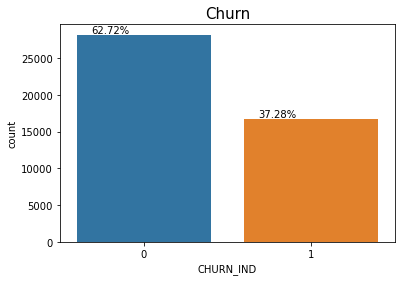

In [27]:
ax = sns.countplot(churn['CHURN_IND'])
ax.set_title("Churn", size = 15)
custNo = churn.shape[0]
for p in ax.patches:
    ax.annotate(f'\n{round((p.get_height()/custNo)*100,2)}%', (p.get_x()+0.2, p.get_height()), ha = 'center', va='bottom', color='black', size=10)

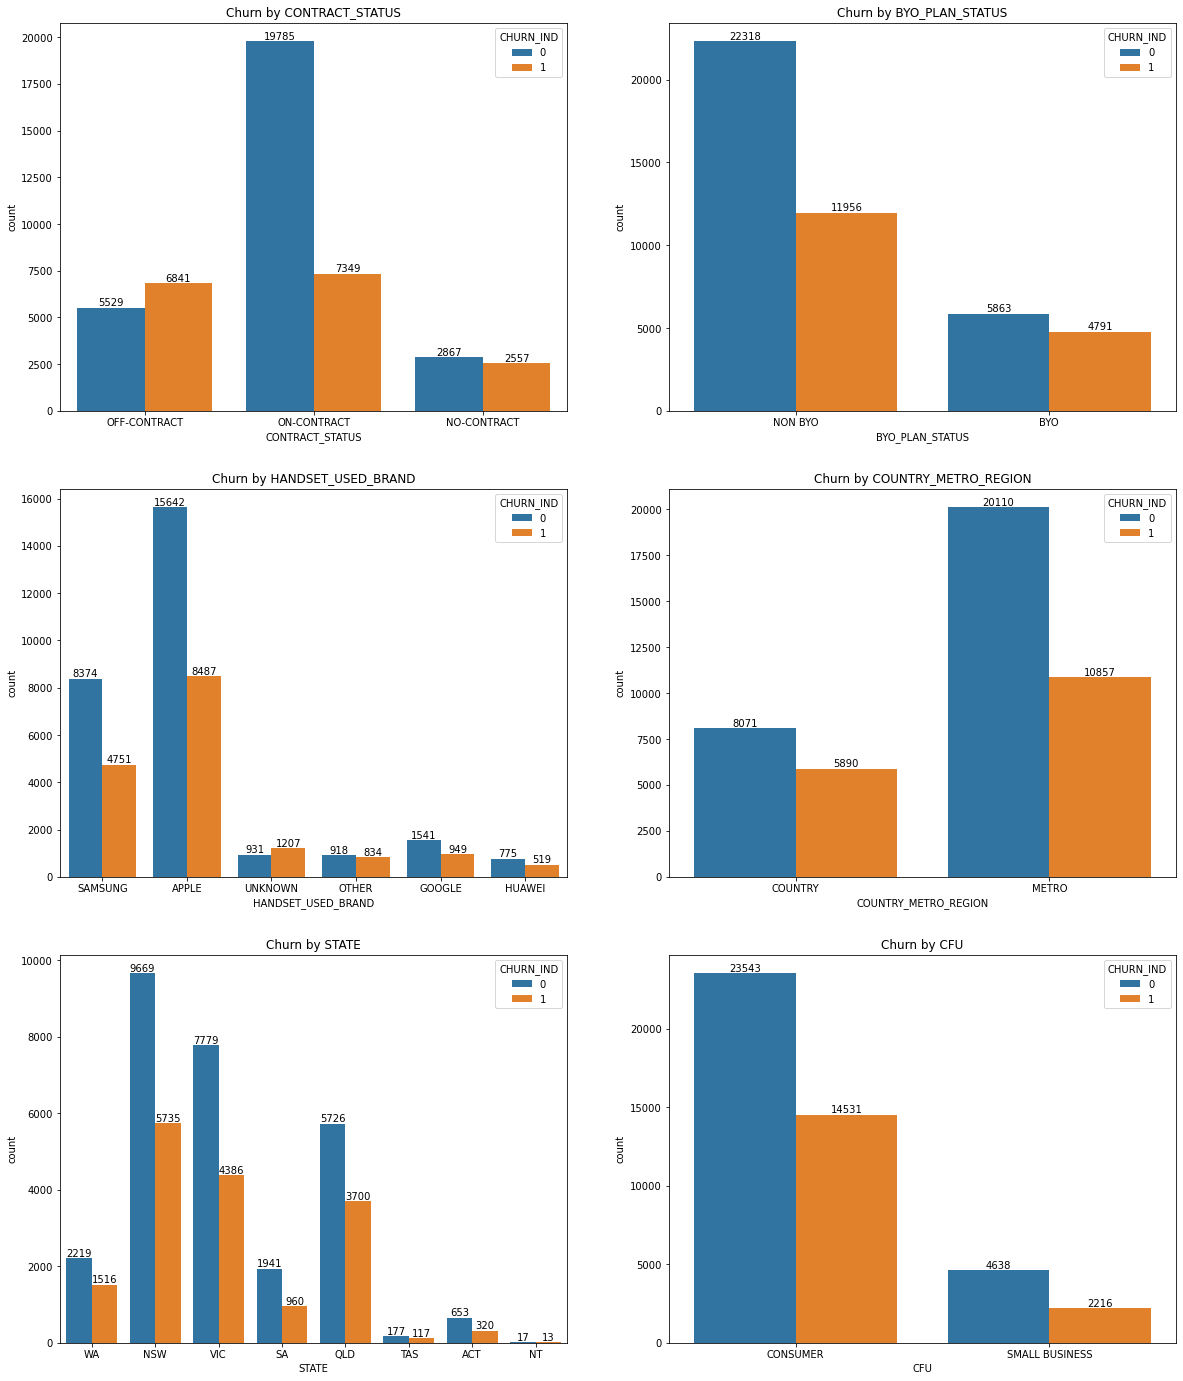

In [28]:
#  Categorical Data
cat = ['CONTRACT_STATUS', 'BYO_PLAN_STATUS', 'HANDSET_USED_BRAND', 'COUNTRY_METRO_REGION', 'STATE', 'CFU']

a = 6  
b = 2 
c = 1  

fig = plt.figure(figsize=(20,50))

for i in cat:
    plt.subplot(a, b, c)
    plt.title('Churn by {}'.format(i))
    plt.xlabel(i)
    ax = sns.countplot(churn[i], hue = churn['CHURN_IND'])
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va='bottom', color='black', size=10)
    c = c + 1


plt.show()

The rate of churn of `CONSUMER` customers is high at 37.28%.

Churn relative to no churn for off-contact customers is greater. This supports the idea that `OFF_CONTRACT` customers are more likely to churn when compared to `ON_CONTRACT` customers possibly due to the greater flexibility they have as they are not locked in by a contract. The `CONTRACT_STATUS` variable will be a suitable variable to include in the model. 

The proportion of `BYO` customers churning is greater then that of `NON-BYO` customers churning. `BYO_PLAN_STATUS` will be a suitable variable to include within the model.

The proportion of churn between customers with `SAMSUNG` or `APPLE` is similar. The HANDSET providers other than `SAMSUNG` and `APPLE` make up a small percentage of total customers. As the proportion of churn between the two major brands are similar this variable may not provide a good indication of churn. The `HANDSET_USED_BRAND` should be excluded from the model.

`COUNTRY` customers are more likely to churn relative to `METRO` customers. The difference in the proportion of churn between `COUNTRY` and `METRO` customers will assist the model in classifying churn. The `COUNTRY_METRO_REGION` variable should be included within the model.

The proportions of churn between the `STATE`'s looks similar and may not be a good indicator of churn. This variable should be excluded from the model. 

The proportion of churn in `SMALL_BUSINESS` is slightly greater compared to `CONSUMERS`. The `CFU` variable may improve the accuracy of the model and should be included.


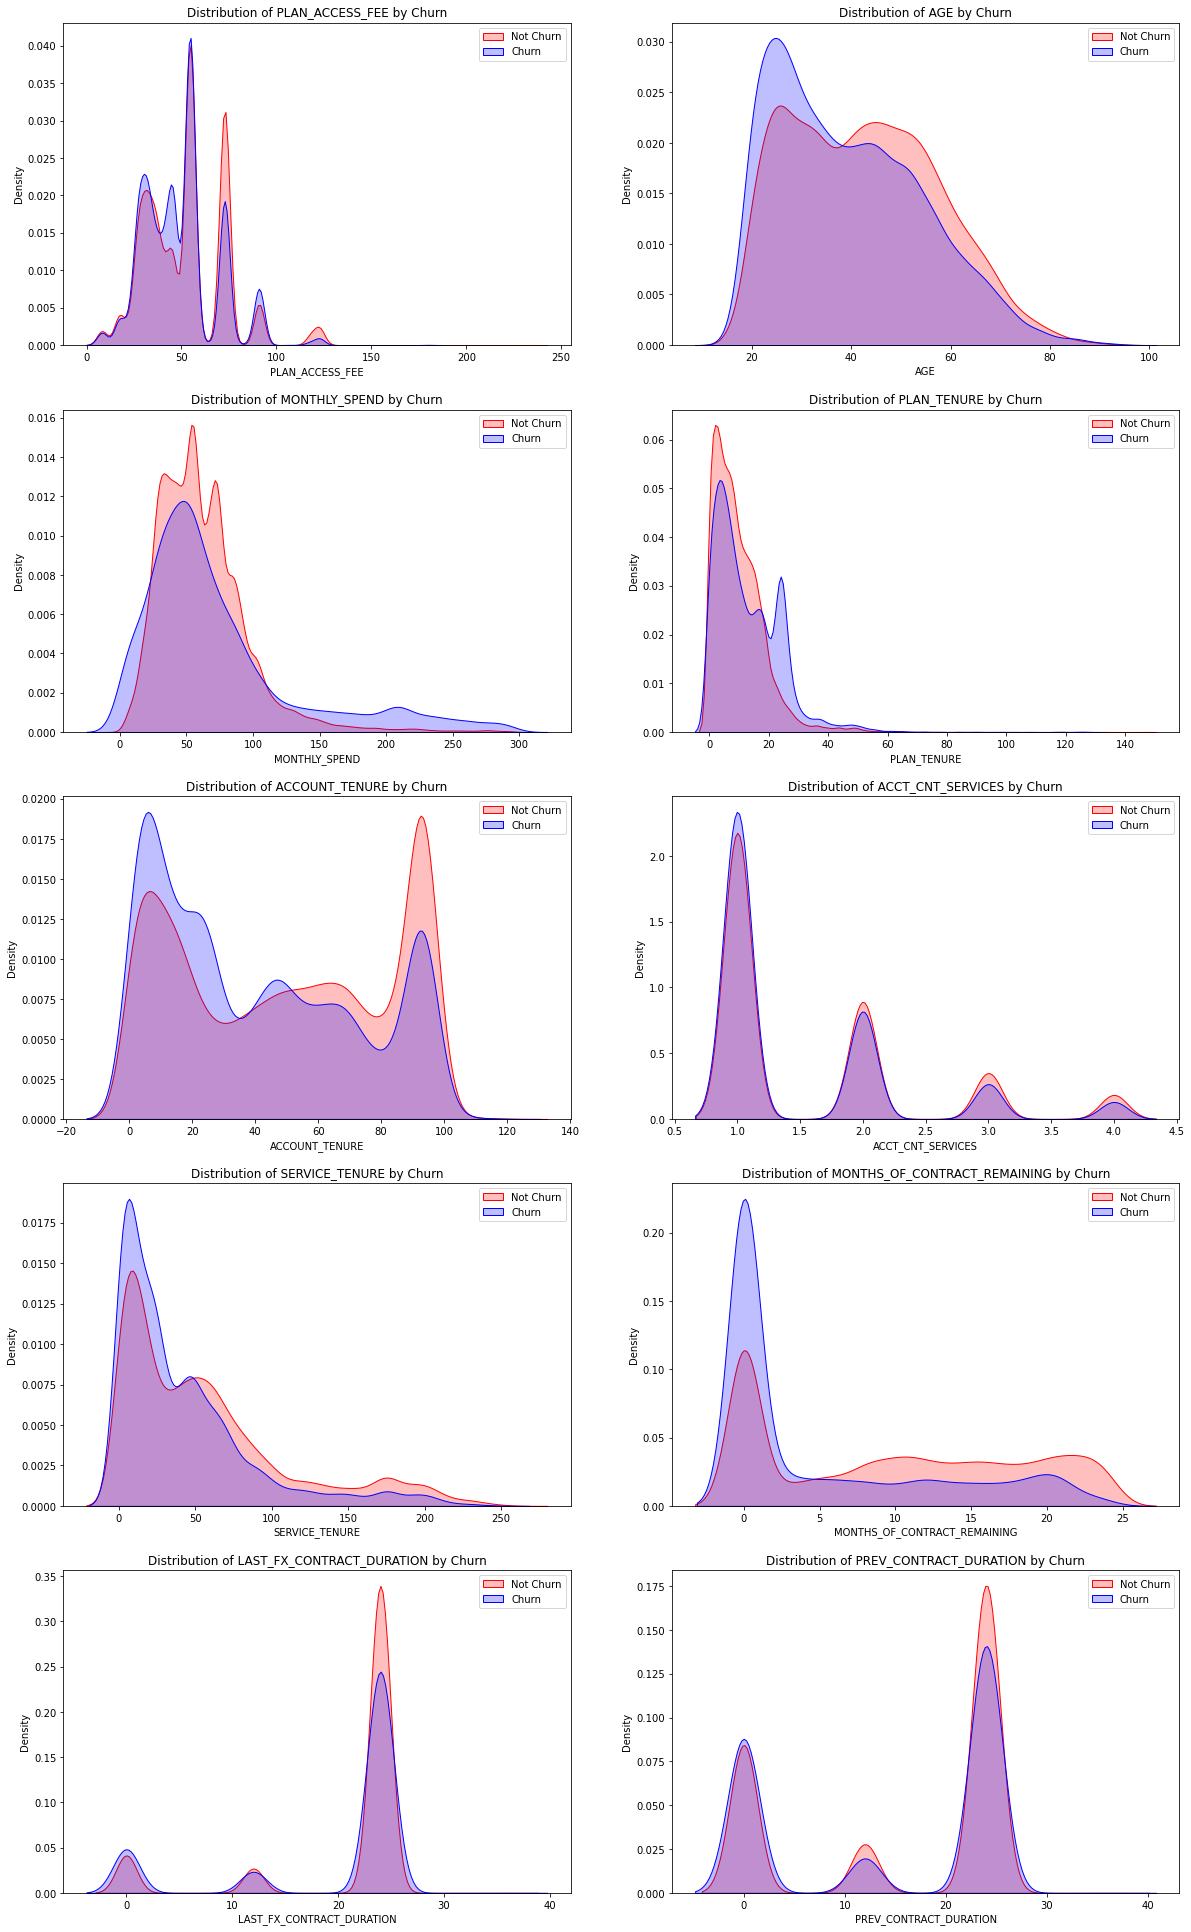

In [29]:
#  Categorical Data
num = ['PLAN_ACCESS_FEE', 'AGE', 'MONTHLY_SPEND', 'PLAN_TENURE', 'ACCOUNT_TENURE', 'ACCT_CNT_SERVICES', 'SERVICE_TENURE', 'MONTHS_OF_CONTRACT_REMAINING', 'LAST_FX_CONTRACT_DURATION', 'PREV_CONTRACT_DURATION']

a = 10  
b = 2 
c = 1  

fig = plt.figure(figsize=(20,70))

for i in num:
    plt.subplot(a, b, c)
    plt.title('Distribution of {} by Churn'.format(i))
    plt.xlabel(i)
    ax = sns.kdeplot(churn[i][(churn['CHURN_IND']==0)],color='Red', shade = True)
    ax = sns.kdeplot(churn[i][(churn['CHURN_IND']==1)],color='Blue', shade = True)
    ax.legend(["Not Churn","Churn"],loc='upper right')
    c = c + 1


plt.show()

There does appear to be a relatively higher rate of churn within `PLAN_ACCESS_FEE`'s around the $45 area. 

There is a higher rate of churn among younger people and a lower rate among older people.

The rate of churn is higher relative to a higher monthly spend. 

A higher rate of churn is evident for `PLAN_TENURE` for periods greater than 20 months. 

The rate of churn is higher for shorter account tenures and lower for longer account tenures. 

The rate of churn appears lower when additional services are linked to the account

Churn is higher for `SERVICE_TENURE` less than 50 and lower for periods greater than 50.

A higher rate of churn can be observed for contracts with a small number of months remaining on the contract compared to those with a longer time period left on the contract.

A lower rate of churn was observed for `LAST_FX_CONTRACT_DURATION` greater then 20 months.

A lower rate of churn was observed for `PREV_CONTRACT_DURATION` greater then 10 months.


<AxesSubplot:title={'center':'Correlation between variables and CHURN_IND'}>

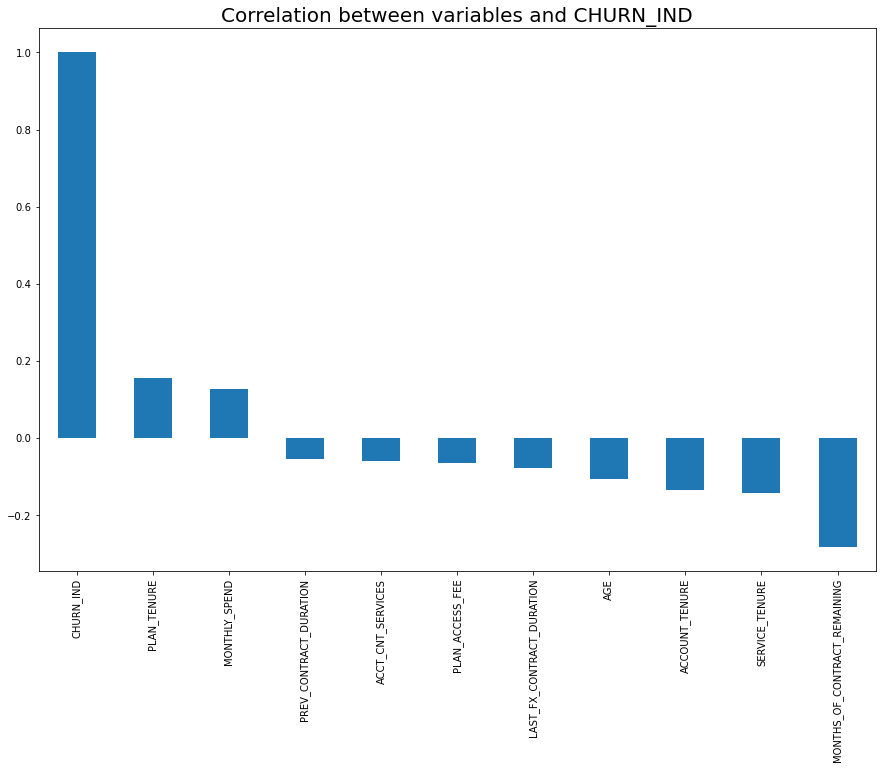

In [30]:
#numerical variable correlation with CHURN_IND
plt.figure(figsize=(15,10))
plt.title("Correlation between variables and CHURN_IND", size = 20)
c = churn.drop(columns='CUST_ID', inplace=False)
c.corr()['CHURN_IND'].sort_values(ascending = False).plot(kind='bar')

No values have a large correlation with churn. 

The variables with the largest positive correlation with churn are `PLAN_TENNURE` and `MONTHLY_SPEND`. 
It would seem that those who spend more each month are more likely to churn. 

The variables with the largest negative correlation with churn are `MONTHS_OF_CONTRACT_REMAINING` and `SERVICE_TENURE`. 
the higher the MONTHS_OF_CONTRACT_REMAINING the less likely a customer will churn. This could be due to a customers inability to leave as they are still on contract. 

`ACCT_CNT_SERVICES` and `PREV_CONTRACT_DURATION` have minimal correlation with churn. As these features have little correlation with churn they will be removed from the model.

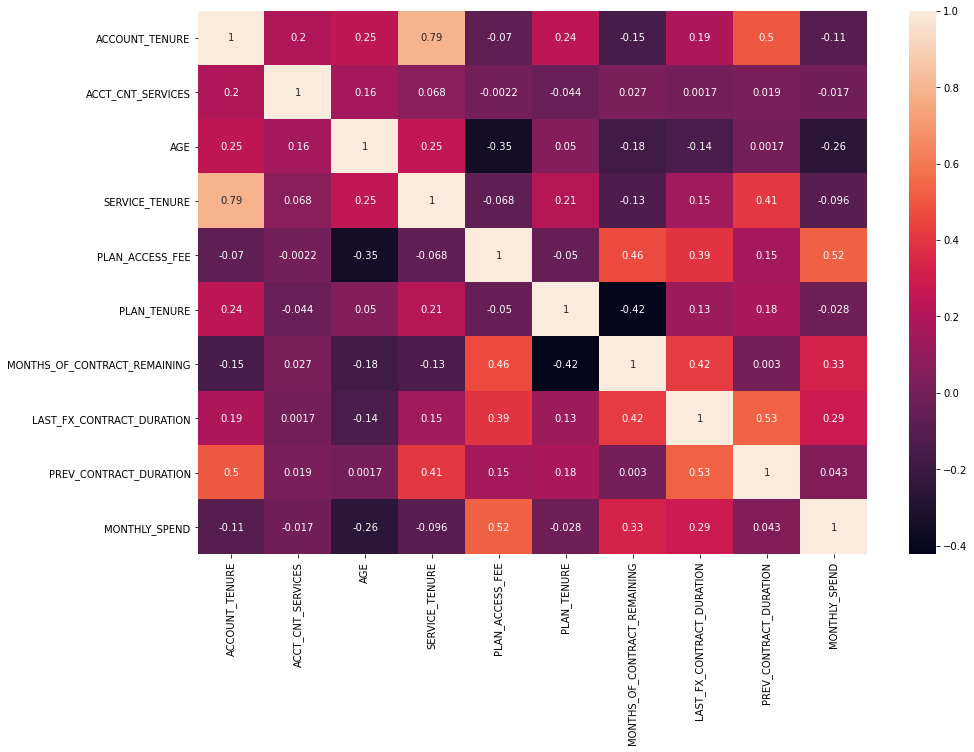

In [31]:
#relationships between variables 
plt.figure(figsize=(15,10))
c = churn.drop(columns=['CUST_ID', 'CHURN_IND'], inplace = False)
ax = sns.heatmap(c.corr(), annot=True)
plt.show()


A strong positive correlation exists between `ACCOUNT_TENNURE` and `SERVICE_TENURE`. Only one of these attributes should be used within the model to prevent multicolinearity. 

Based upon the investigation of relationships between the independent variables and churn, the following attributes were selected for the model:


* `CONTRACT_STATUS` 
* `BYO_PLAN_STATUS`
* `COUNTRY_METRO_REGION`
* `CFU`
* `PLAN_ACCESS_FEE`
* `AGE`
* `MONTHLY_SPEND`
* `PLAN_TENURE`
* `SERVICE_TENURE`
* `MONTHS_OF_CONTRACT_REMAINING`
* `LAST_FX_CONTRACT_DURATION`

## 3.4 Converting categorical variables to dummy variables

In [32]:
#dropping attributes from data set
churn_model = churn.drop(columns=['CUST_ID', 'ACCOUNT_TENURE', 'ACCT_CNT_SERVICES', 'PREV_CONTRACT_DURATION', 'HANDSET_USED_BRAND', 'STATE'])

In [33]:
#BYO_PLAN_STATUS_le column added -> 0 = NON BYO, 1 = BYO
churn_model.insert(5,'BYO_PLAN_STATUS_le', 0)
churn_model.BYO_PLAN_STATUS_le[churn_model.BYO_PLAN_STATUS == 'BYO'] = 1
churn_model.drop(columns='BYO_PLAN_STATUS', inplace=True)
#CFU_le column added -> 0 = SMALL BUSINESS, 1 = CONSUMER
churn_model.insert(2,'CFU_le', 0)
churn_model.CFU_le[churn_model.CFU == 'CONSUMER'] = 1
churn_model.drop(columns='CFU', inplace=True)
#ON-CONTRACT column added -> 0 = NO, 1 = YES
churn_model.insert(9,'ON_CONTRACT', 0)
churn_model.ON_CONTRACT[churn_model.CONTRACT_STATUS == 'ON-CONTRACT'] = 1
#OFF-CONTRACT column added -> 0 = NO, 1 = YES
churn_model.insert(9,'OFF_CONTRACT', 0)
churn_model.OFF_CONTRACT[churn_model.CONTRACT_STATUS == 'OFF-CONTRACT'] = 1
churn_model.drop(columns='CONTRACT_STATUS', inplace=True)
#COUNTRY_METRO_REGION_le column added -> 0 = COUNTRY BYO, 1 = METRO
churn_model.insert(13,'COUNTRY_METRO_REGION_le', 0)
churn_model.COUNTRY_METRO_REGION_le[churn_model.COUNTRY_METRO_REGION == 'METRO'] = 1
churn_model.drop(columns='COUNTRY_METRO_REGION', inplace=True)

In [34]:
churn_model.head()

AGE  CFU_le  SERVICE_TENURE  PLAN_ACCESS_FEE  BYO_PLAN_STATUS_le  \
INDEX                                                                      
1      30.0       1              46            54.54                   0   
2      55.0       1              59            54.54                   0   
3      29.0       1              65            40.90                   1   
4      51.0       1              31            31.81                   0   
5      31.0       1              95            54.54                   0   

       PLAN_TENURE  MONTHS_OF_CONTRACT_REMAINING  LAST_FX_CONTRACT_DURATION  \
INDEX                                                                         
1               15                             0                         24   
2                5                             0                         24   
3               15                             0                         12   
4               31                             0                         24   
5                0                             0                         24   

       OFF_CONTRACT  ON_CONTRACT  CHURN_IND  MONTHLY_SPEND  \
INDEX                                                        
1                 1            0          1          61.40   
2                 1            0          1          54.54   
3                 1            0          1           2.50   
4                 1            0          1           6.48   
5                 1            0          1         100.22   

       COUNTRY_METRO_REGION_le  
INDEX                           
1                            0  
2                            1  
3                            0  
4                            0  
5                            1

## 3.5 Splitting Training and Testing Datasets

In [35]:
#data split, 80% training, 20% testing 
train, test = train_test_split(churn_model, test_size=0.2, stratify=churn_model['CHURN_IND'], random_state=7)
print(train.shape)
print(test.shape)

(35942, 13)
(8986, 13)


In [36]:
# Getting input data and targets for model
X_train = train.drop(['CHURN_IND'], axis=1)
y_train = train['CHURN_IND']
X_test = test.drop(['CHURN_IND'], axis=1)
y_test = test['CHURN_IND']

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (35942, 12)
y_train shape:  (35942,)
X_test shape:  (8986, 12)
y_test shape:  (8986,)


## 3.6 Logistic Regression Model

### 3.6.1 Fitting the Model

In [37]:
# Training Logistic Regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [38]:
# Doing predictions on train and test set
y_hat_train = lr.predict(X_train)
y_hat_test = lr.predict(X_test)

### 3.6.2 Evaluation

In [39]:
# Evaluate the performance of your trained model
print(f'Acc on training set: {accuracy_score(y_train,y_hat_train)}')
print(f'Acc on test set: {accuracy_score(y_test,y_hat_test)}')

Acc on training set: 0.7204941294307495
Acc on test set: 0.7180057867794347


The accuracey of the model is moderate. The accuracy score between the test data and training data is similar indicating no overfitting. 

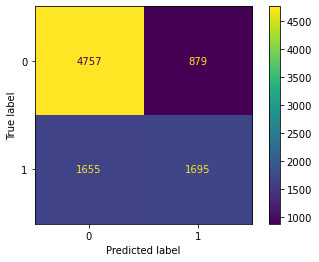

In [40]:
# Checking confusion matrix
plot_confusion_matrix(lr, X_test, y_test)
plt.show()

The model correctly predicted 4757 instances of no churn and 1695 instances of churn. 

The model generated 1655 false negatives and 879 false positives. False negatives are the most concerning as they result in the incorrect prediction of a customer staying when the customer has churned. This is the most costly outcome for the business. The number of false negatives is relatively high suggesting this model may not be approriate to accuratley model churn. 

In [41]:
# to increment number of features, one at each time
acc_scores = []
for i in range(1,13):
    clf = LogisticRegression()
    rfe = RFE(estimator=clf, n_features_to_select=i)
    # training model
    rfe.fit(X_train, y_train)
    # predicting on test set
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    # print this
    print("Acc on test set using", i, "features: ", acc_score)
    # append to the list
    acc_scores.append(acc_score)

Acc on test set using 1 features:  0.650233696861785
Acc on test set using 2 features:  0.6721566881816159
Acc on test set using 3 features:  0.6677053193857111
Acc on test set using 4 features:  0.6705987091030492
Acc on test set using 5 features:  0.6713776986423325
Acc on test set using 6 features:  0.6726018250612064
Acc on test set using 7 features:  0.6892944580458491
Acc on test set using 8 features:  0.7082127754284443
Acc on test set using 9 features:  0.717338081460049
Acc on test set using 10 features:  0.716447807700868
Acc on test set using 11 features:  0.7202314711773871
Acc on test set using 12 features:  0.7180057867794347


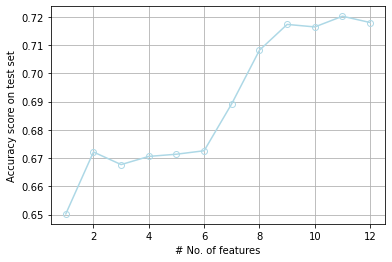

In [42]:
plt.grid()   
plt.xlabel('# No. of features')
plt.ylabel('Accuracy score on test set')
plt.plot(range(1, 13), acc_scores, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,
         markeredgecolor = 'lightblue', markerfacecolor = 'None')

Upon the application of the recursive feature application function it was found that the highest accuracy score was achieved  with 11 features. Upon investigation it was found that the `LAST_FX_CONTRACT_DURATION` attribute was reducing the accuracy of the model. This attribute was removed from the model and the model refit. 

### 3.6.3 Re-fitting Adjusted Model 

In [43]:
#removal of LAST_FX_CONTRACT_DURATION attribute
churn_model.drop(columns='LAST_FX_CONTRACT_DURATION', inplace=True)

In [44]:
#data split, 80% training, 20% testing 
train, test = train_test_split(churn_model, test_size=0.2, stratify=churn_model['CHURN_IND'], random_state=7)
# Getting input data and targets for model
X_train = train.drop(['CHURN_IND'], axis=1)
y_train = train['CHURN_IND']
X_test = test.drop(['CHURN_IND'], axis=1)
y_test = test['CHURN_IND']

In [45]:
# Training Logistic Regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [46]:
# Doing predictions on train and test set
y_hat_train = lr.predict(X_train)
y_hat_test = lr.predict(X_test)

### 3.6.4 Adjusted model evaluation

In [47]:
# Evaluate the performance of your trained model
print(f'Acc on training set: {accuracy_score(y_train,y_hat_train)}')
print(f'Acc on test set: {accuracy_score(y_test,y_hat_test)}')

Acc on training set: 0.7198542095598465
Acc on test set: 0.7202314711773871


The test and training data accuracy scores are similar indicating no overfitting.

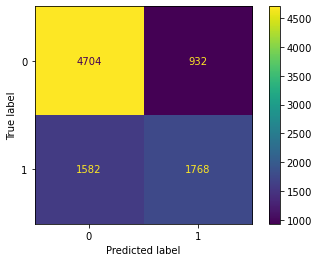

In [48]:
# Checking confusion matrix
plot_confusion_matrix(lr, X_test, y_test)
plt.show()

While the accuracy scorce between the original and re-fit models is similar. The refit model has a slightly less false negatives. This may make the re-fit model more useful. 

## 3.7 Conclusion

A logistic regression model was used to classify churn of customers within the Optus data set. 
Exploration of the data resulted in the identification of outliers within the `MONTHLY_SPEND`. Outliers that were found to be 3 standard deviations from the mean were removed. 
A number of discrepancies were identified within the `AGE` attribute, including nulls and a number of very large and small values. This was found to be due to the differences in customer type identified within the `CFU` attribute. These values made up small percentage of customers and were removed from the data set. 
The relationships between the independent and target variable were explored and based on what was found attributes were selected for modelling based on suitability. 
Prior to fitting the model, the data was split into a 80% training and 20% test set for model validation purposes. As the distribution of churn within the dataset was unbalanced the data set was stratified on `CHURN_IND`.
The initial model produced a moderate level of accuracy correctly classifying of 71.80% of the test data as either churned or not churned. The confusion matrix showed 1695 customers were correctly predicted as churned, however 1655 false negatives were observed. This indicates that the model only predicted 50.6% of the customers who had churned.
The recursive feature application function was applied to the model and it was found that the model could be improved with the removal of the `LAST_FX_CONTRACT_DURATION` attribute. This attribute was removed and the model was refit. 
Upon refitting the model the accuracy of predicting churn improved slightly to 72.02% of the test data. The confusion matrix showed an improvement in the number of false negatives. The refit model was able to predict 53% of the customers who had churned.
While the re-fit model is an improvement it may not produce a high enough recall result to be useful. 
The final model included the following attributes:
* `CONTRACT_STATUS` 
* `BYO_PLAN_STATUS`
* `COUNTRY_METRO_REGION`
* `CFU`
* `PLAN_ACCESS_FEE`
* `AGE`
* `MONTHLY_SPEND`
* `PLAN_TENURE`
* `SERVICE_TENURE`
* `MONTHS_OF_CONTRACT_REMAINING`

